# 0. Imports

In [175]:
import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import os
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from scipy.interpolate import interp1d

from moepy import lowess
from scipy.optimize import curve_fit # for power curve fitting
import sys
# appending a path with my modules
sys.path.append(r'W:\PD-Engines\Engine Integration Validation\Department\Data Analytics\Wiktor\Python')
import Helpers

sns.set_theme()

color_dict = {'WTG15' : sns.color_palette()[0], #bluish
              'WTG15 LEP' : sns.color_palette()[3], # redish
              'WTG15 transition period' : sns.color_palette()[2],    #green
              'WTG16' : sns.color_palette()[4],
              'WTG12' : sns.color_palette()[5],
              'WTG15 2024_08_to_12' : sns.color_palette()[1]} # orange

In [30]:
from utilities import (
    clean_data,
    fit_logistic_power_curve,
    fit_lowess_power_curve,
    get_uniform_windspeed_distribution,
    logistic,
    initial_filter_over_1dcurve,
    fit_power_curve_poly6,
    fit_power_curve_IEC,
    calculate_filter_1dcurve,
    fit_linear_regression,
    calculate_filter_1dcurve_hp
)

In [31]:
def load_data_2025(path):
    df_list = []
    for file in Helpers.get_files(path, extension='.xlsx'):
        df_temp = pd.read_excel(file, engine='openpyxl')
        df_temp['WTG'] = os.path.basename(file).split('-')[0].strip()
        df_list.append(df_temp)
    return pd.concat(df_list, ignore_index=True)

# 1. Load data

In [4]:
# df_raw = load_data_2025('data\\')
# df_raw['Moc czynna (avg) [kW]'] = df_raw['Moc czynna (avg) [W]'] / 1000
#df_raw.to_parquet('data\\raw_data_14_01_2026.parquet')
df_raw = pd.read_parquet('data\\raw_data_14_01_2026.parquet')

In [5]:
df_raw

,Sygnatura czasowa,Temp otoczenia (avg) [°C],Kierunek wiatru Główny wiatrowskaz (avg) [°],Prędkość wiatru Główny anemometr (avg) [m/s],Kierunek Gondola (avg) [°],Całkowita produkcja energii czynnej (sum) [Wh],Moc czynna (avg) [W],Bezwzględny kierunek wiatru LaPM (avg) [°],Względny kierunek wiatru Główny wiatrowskaz (avg) [°],Czas pracy (co godzinę) [%],WTG,Całkowita produkcja energii biernej (sum) [VArh],Moc czynna (avg) [kW]
0,2023-01-01 00:10:00,14.0,220.0,13.3,221.0,444355.0,2709000.0,0.0,-1.0,NaN,WTG12,NaN,2709.000
1,2023-01-01 00:20:00,14.0,222.0,13.1,221.0,395165.0,2344300.0,0.0,1.0,NaN,WTG12,NaN,2344.300
2,2023-01-01 00:30:00,14.0,225.0,12.8,224.0,299918.0,1799400.0,0.0,1.0,NaN,WTG12,NaN,1799.400
3,2023-01-01 00:40:00,14.0,223.0,12.9,227.0,300029.0,1800199.0,0.0,-4.0,NaN,WTG12,NaN,1800.199
4,2023-01-01 00:50:00,15.0,224.0,13.8,223.0,300043.0,1800199.0,0.0,1.0,NaN,WTG12,NaN,1800.199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
460033,2025-11-30 23:30:00,4.0,207.0,8.3,207.0,NaN,1053800.0,0.0,0.0,NaN,WTG16,8165.0,1053.800
460034,2025-11-30 23:40:00,4.0,207.0,8.5,208.0,NaN,1057300.0,0.0,-2.0,NaN,WTG16,8166.0,1057.300
460035,2025-11-30 23:50:00,4.0,204.0,8.3,206.0,NaN,1017900.0,0.0,-2.0,NaN,WTG16,8164.0,1017.900
460036,2025-12-01 00:00:00,4.0,205.0,8.2,203.0,NaN,990000.0,0.0,2.0,NaN,WTG16,8173.0,990.000


## 1.1 Correct WTG periods for when LEP was applied

Info from Naviga:
* Blade A 02/07/2025
* Blade B 07/08/2025
* Blade C 08/08/2025

so data from 02/07 - 08/08 should not be used 

In [6]:
df_raw.loc[
    df_raw['Sygnatura czasowa'].between(pd.to_datetime('2025/07/02'), pd.to_datetime('2025/08/08')), 
    'WTG'] = 'WTG15 transition period'
df_raw.loc[df_raw['Sygnatura czasowa'] >= pd.to_datetime('2025/08/08'), 'WTG'] = 'WTG15 LEP'

In [7]:
df_raw[df_raw['Sygnatura czasowa'].between(pd.to_datetime('2025/07/02'), pd.to_datetime('2025/08/08'))]

,Sygnatura czasowa,Temp otoczenia (avg) [°C],Kierunek wiatru Główny wiatrowskaz (avg) [°],Prędkość wiatru Główny anemometr (avg) [m/s],Kierunek Gondola (avg) [°],Całkowita produkcja energii czynnej (sum) [Wh],Moc czynna (avg) [W],Bezwzględny kierunek wiatru LaPM (avg) [°],Względny kierunek wiatru Główny wiatrowskaz (avg) [°],Czas pracy (co godzinę) [%],WTG,Całkowita produkcja energii biernej (sum) [VArh],Moc czynna (avg) [kW]
131455,2025-07-02 00:00:00,21.0,135.0,3.4,130.0,12778.0,77199.0,0.0,5.0,NaN,WTG15 transition period,NaN,77.199
131456,2025-07-02 00:10:00,22.0,146.0,4.0,145.0,20904.0,126000.0,0.0,1.0,NaN,WTG15 transition period,NaN,126.000
131457,2025-07-02 00:20:00,22.0,147.0,5.0,146.0,28139.0,169399.0,0.0,1.0,NaN,WTG15 transition period,NaN,169.399
131458,2025-07-02 00:30:00,22.0,150.0,5.5,146.0,34603.0,207600.0,0.0,4.0,NaN,WTG15 transition period,NaN,207.600
131459,2025-07-02 00:40:00,22.0,151.0,5.4,146.0,33876.0,202899.0,0.0,5.0,NaN,WTG15 transition period,NaN,202.899
...,...,...,...,...,...,...,...,...,...,...,...,...,...
443471,2025-08-07 23:20:00,20.0,180.0,7.9,182.0,126160.0,755000.0,0.0,-3.0,NaN,WTG15 transition period,NaN,755.000
443472,2025-08-07 23:30:00,20.0,179.0,7.6,182.0,117345.0,704900.0,0.0,-3.0,NaN,WTG15 transition period,NaN,704.900
443473,2025-08-07 23:40:00,19.0,180.0,7.8,182.0,128610.0,772799.0,0.0,-2.0,NaN,WTG15 transition period,NaN,772.799
443474,2025-08-07 23:50:00,19.0,182.0,8.2,182.0,139815.0,840000.0,0.0,-1.0,NaN,WTG15 transition period,NaN,840.000


# 2. Filter data

Ideally try to download IEC 61400-12-1 - it's a document on general norms for analyzing this kind of data, it has filtering info as well.

## 2.1 Remove negative powers and unrealistic points

Wtf that's not expected, double check energy production? Why max power is now at 3k while previously it was at ~2.5k

Text(0.5, 1.0, 'Initial data filtering zone ')

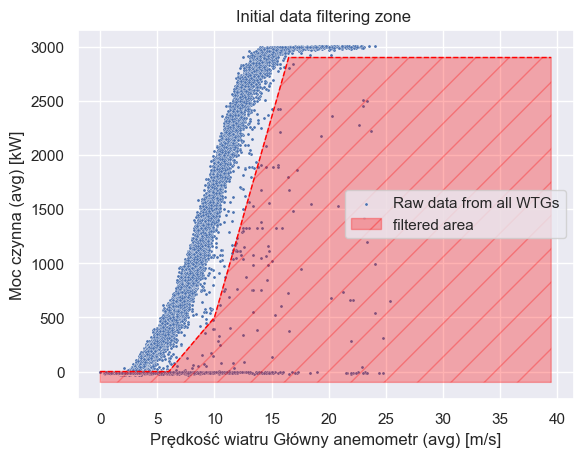

In [12]:
fig, ax = plt.subplots()
filtering_curve = calculate_filter_1dcurve_hp()
sns.scatterplot(data=df_raw.iloc[::10], s=5, x='Prędkość wiatru Główny anemometr (avg) [m/s]', y='Moc czynna (avg) [kW]', label='Raw data from all WTGs', ax=ax)
sns.lineplot(x=np.arange(0, 40, 0.5), y=filtering_curve(np.arange(0, 40, 0.5)), label='_filtering curve', ax=ax, color='red', linestyle='--', linewidth =1)
ax.fill_between(np.arange(0, 40, 0.5), filtering_curve(np.arange(0, 40, 0.5)), y2= -100, color='red', alpha=0.3, hatch='/', label='filtered area')
plt.legend()
plt.title('Initial data filtering zone ')

In [13]:
print(f'Length before filtering: {len(df_raw)}')
df = initial_filter_over_1dcurve(df_raw, x_col='Prędkość wiatru Główny anemometr (avg) [m/s]', y_col='Moc czynna (avg) [kW]', filtering_curve=filtering_curve)
print(f'Length after filtering: {len(df)}')

Length before filtering: 460038
Length after filtering: 382093


# 3. Scatter plot

In [48]:
df_raw['WTG'].unique()

array(['WTG12', 'WTG15 transition period', 'WTG15 LEP', 'WTG15', 'WTG16'],
      dtype=object)

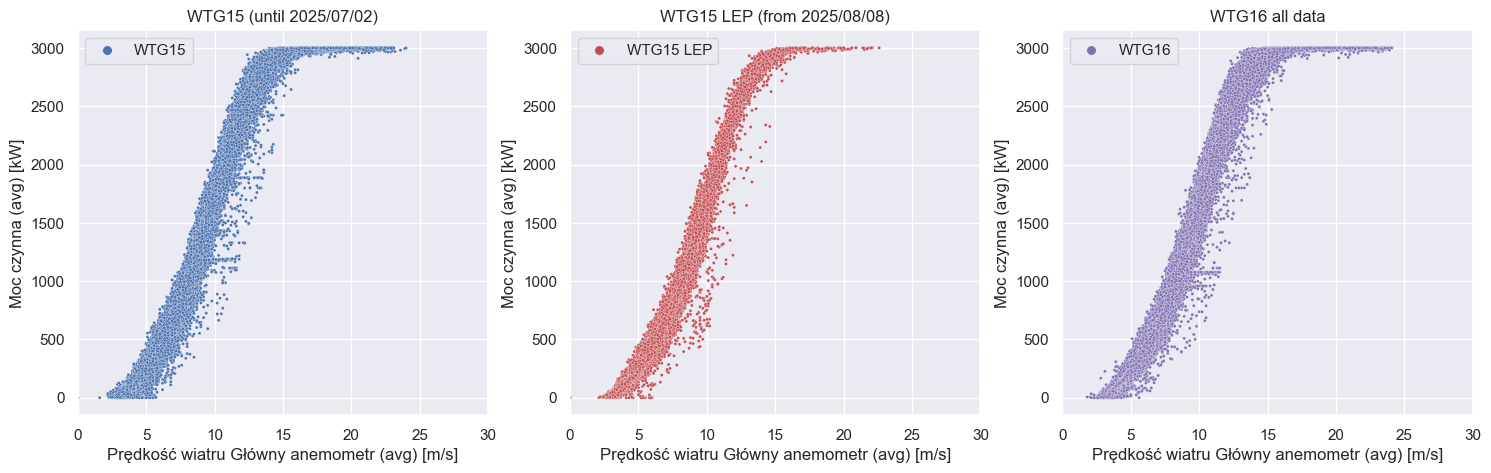

In [49]:
fig, axes = plt.subplots(1,3, figsize=(18, 5))
sns.scatterplot(data=df[df['WTG']=='WTG15'], s=5, x='Prędkość wiatru Główny anemometr (avg) [m/s]', y='Moc czynna (avg) [kW]', hue='WTG', ax=axes[0], palette=color_dict)
sns.scatterplot(data=df[df['WTG']=='WTG15 LEP'], s=5, x='Prędkość wiatru Główny anemometr (avg) [m/s]', y='Moc czynna (avg) [kW]', hue='WTG', ax=axes[1], palette=color_dict)
sns.scatterplot(data=df[df['WTG']=='WTG16'], s=5, x='Prędkość wiatru Główny anemometr (avg) [m/s]', y='Moc czynna (avg) [kW]', hue='WTG', ax=axes[2], palette=color_dict)

axes[0].set_title('WTG15 (until 2025/07/02)')
axes[1].set_title('WTG15 LEP (from 2025/08/08)')
axes[2].set_title('WTG16 all data')
for ax in axes:
    ax.set_xlim((0,30))
    ax.legend(markerscale=3).set_title(None)


C:\Users\wikto\AppData\Local\Temp\ipykernel_25860\3251209703.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=60)
C:\Users\wikto\AppData\Local\Temp\ipykernel_25860\3251209703.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=60)
C:\Users\wikto\AppData\Local\Temp\ipykernel_25860\3251209703.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=60)


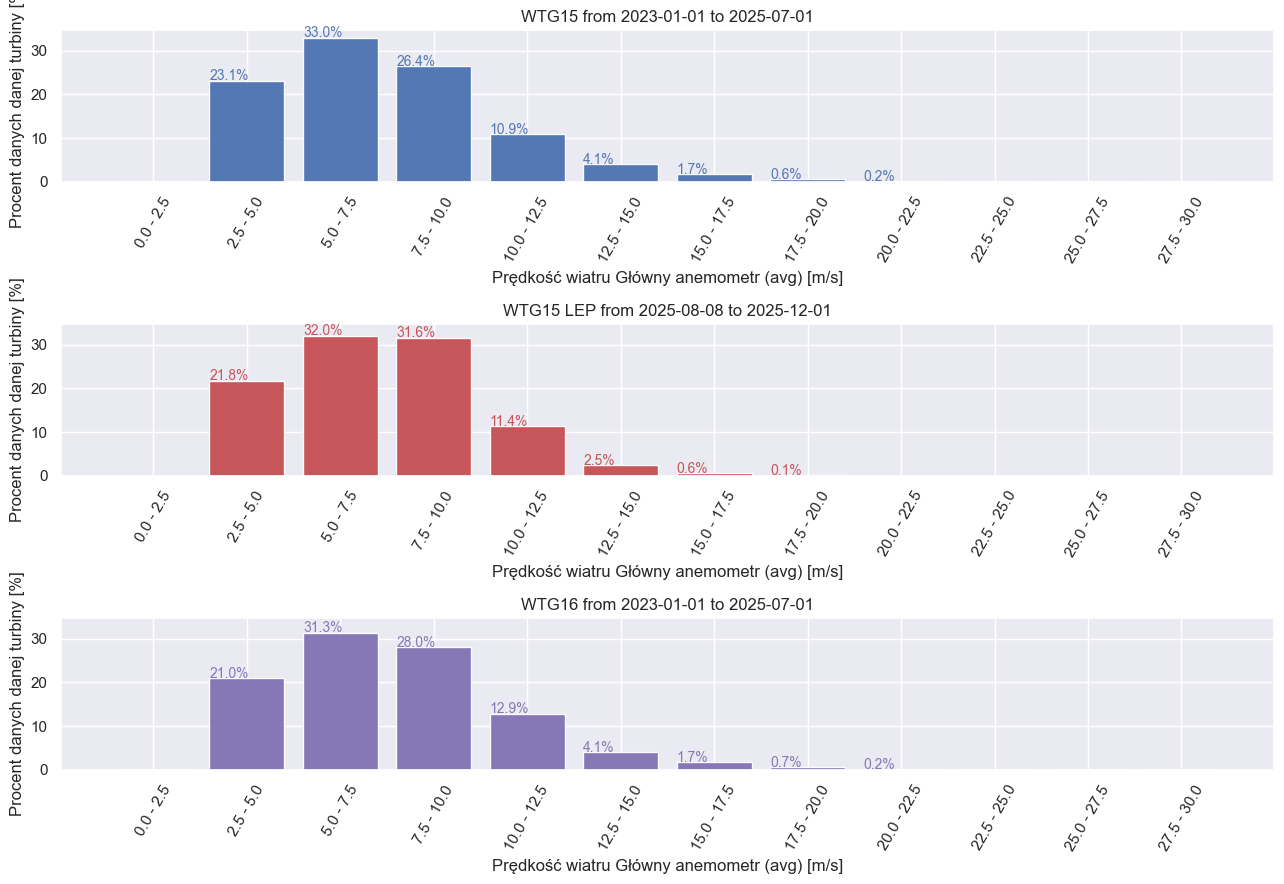

In [157]:
bins=np.arange(0, 31, 2.5)
labels = [f'{b} - {b+bins[1]-bins[0]}' for b in bins[:-1]]

fig, axes = plt.subplots(3, 1, figsize=(13, 9), sharey=True)
for i, wtg in enumerate(['WTG15', 'WTG15 LEP', 'WTG16']):
    ax = axes.flatten()[i]
    df_temp =  df[df['WTG'] == wtg]
    c, bins = np.histogram(df_temp['Prędkość wiatru Główny anemometr (avg) [m/s]'], bins=bins)
    ax.bar(x=labels, height=c/sum(c)*100, color=color_dict[wtg], alpha=0.95)
    Helpers.add_plt_annotations(ax, suffix='%', text_color_diff=True, skip_smaller_than=0.1)
    ax.set_title(f"{wtg} from {df_temp['Sygnatura czasowa'].dt.date.min()} to {df_temp['Sygnatura czasowa'].dt.date.max()}")
    ax.set_xlabel('Prędkość wiatru Główny anemometr (avg) [m/s]')
    ax.set_ylabel('Procent danych danej turbiny [%]')
    ax.set_xticklabels(labels, rotation=60)
plt.tight_layout()

# 4. Total Energy production

In [22]:
df.columns

Index(['Sygnatura czasowa', 'Temp otoczenia (avg) [°C]',
       'Kierunek wiatru Główny wiatrowskaz (avg) [°]',
       'Prędkość wiatru Główny anemometr (avg) [m/s]',
       'Kierunek Gondola (avg) [°]',
       'Całkowita produkcja energii czynnej (sum) [Wh]',
       'Moc czynna (avg) [W]', 'Bezwzględny kierunek wiatru LaPM (avg) [°]',
       'Względny kierunek wiatru Główny wiatrowskaz (avg) [°]',
       'Czas pracy (co godzinę) [%]', 'WTG',
       'Całkowita produkcja energii biernej (sum) [VArh]',
       'Moc czynna (avg) [kW]', 'WTG_simple', 'Wyprodukowana Energia [MWh]'],
      dtype='object')

In [23]:
df['WTG_simple'] = df['WTG'].str.split(' ').str[0]
df['WTG_simple'].unique()

array(['WTG12', 'WTG15', 'WTG16'], dtype=object)

In [24]:
df = df.sort_values(by=['WTG_simple', 'Sygnatura czasowa'])
df['Wyprodukowana Energia [MWh]'] = df.groupby('WTG_simple')['Całkowita produkcja energii czynnej (sum) [Wh]'].cumsum() / 1000 / 1000

C:\Users\wikto\AppData\Local\Temp\ipykernel_25860\3244099602.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot = df.dropna(subset=['Sygnatura czasowa', 'Wyprodukowana Energia [MWh]'])[df['WTG_simple']==wtg]
C:\Users\wikto\AppData\Local\Temp\ipykernel_25860\3244099602.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot = df.dropna(subset=['Sygnatura czasowa', 'Wyprodukowana Energia [MWh]'])[df['WTG_simple']==wtg]
C:\Users\wikto\AppData\Local\Temp\ipykernel_25860\3244099602.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot = df.dropna(subset=['Sygnatura czasowa', 'Wyprodukowana Energia [MWh]'])[df['WTG_simple']==wtg]


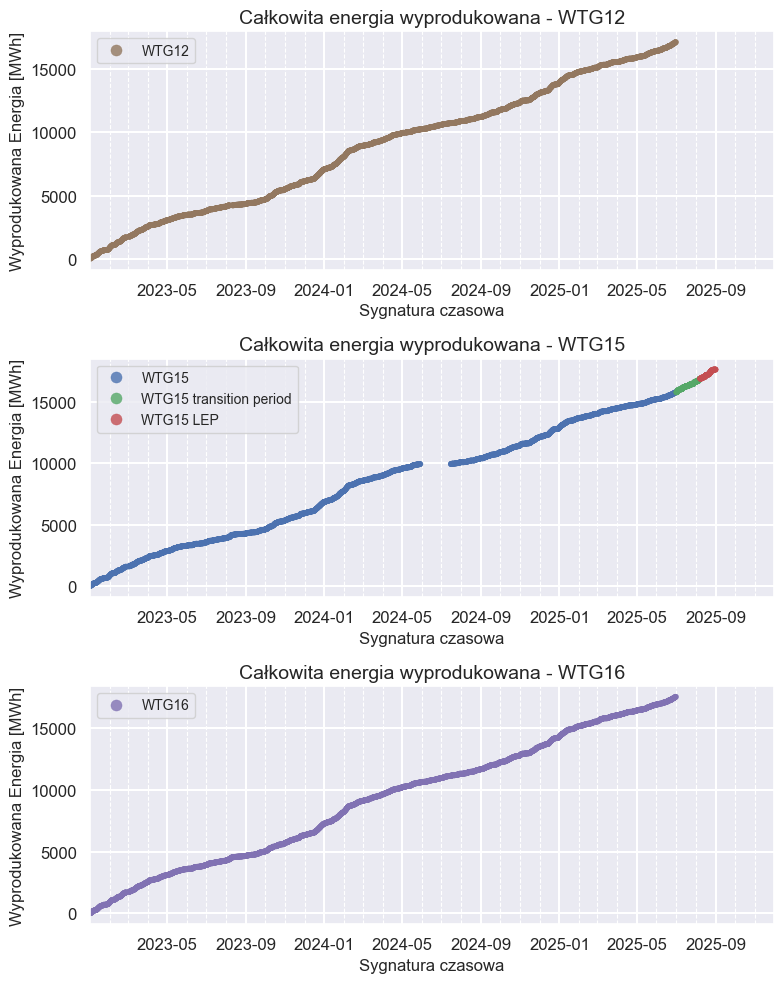

In [25]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(nrows=3, figsize=(8, 10))
for i, wtg in enumerate(df['WTG_simple'].unique()):
    ax = axes[i]
    df_plot = df.dropna(subset=['Sygnatura czasowa', 'Wyprodukowana Energia [MWh]'])[df['WTG_simple']==wtg]
    sns.scatterplot(df_plot.iloc[::50],
                     x='Sygnatura czasowa', y='Wyprodukowana Energia [MWh]', hue='WTG',
                     s=15, alpha=0.8, ax=ax, edgecolor=None, palette=color_dict)
    ax.set_title(f'Całkowita energia wyprodukowana - {wtg}')
    lgnd = ax.legend(loc="upper left", fontsize=10)
    for handle in lgnd.legend_handles:
        handle.set_markersize(8)
    ax.set_xlim(df['Sygnatura czasowa'].min(), df['Sygnatura czasowa'].max())
    # minor ticks every month
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    # major ticks every 4 months
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax.grid(which='major', linestyle='-', linewidth=1.5, color='white')
    ax.grid(which='minor', linestyle='--', linewidth=0.8, color='white')  # minor grid lines
    #ax.set_xticks(pd.date_range(start=df['Sygnatura czasowa'].min(), end=df['Sygnatura czasowa'].max(), freq='4M'))
    #ax.set_xticklabels(rotation=30)
    # make all text (title, labels, ticks) bigger
    ax.tick_params(axis='both', which='major', labelsize=12)
    # make title and labels bigger
    ax.title.set_fontsize(14)
    ax.xaxis.label.set_fontsize(12)
    ax.yaxis.label.set_fontsize(12)

plt.tight_layout()

Text(0.5, 1.0, 'Całkowita energia wyprodukowana - wszystkie WTG')

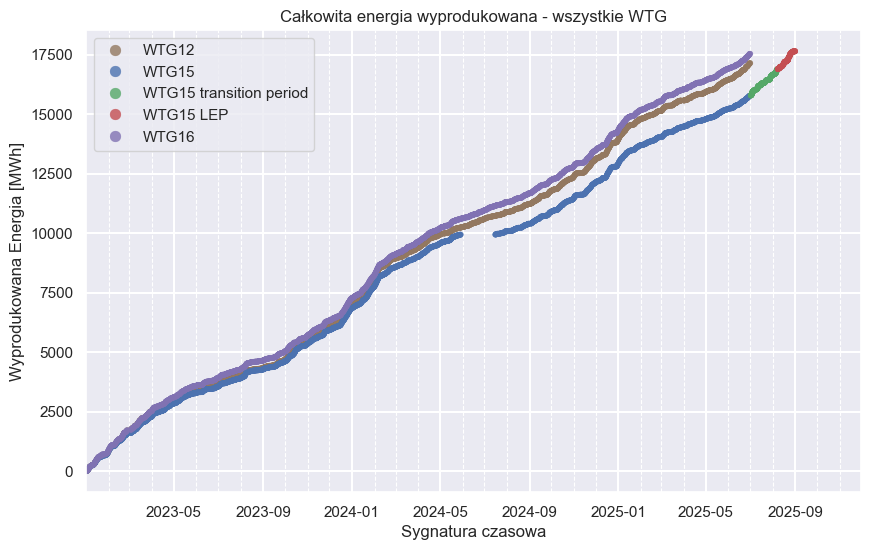

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(df.iloc[::50],
                    x='Sygnatura czasowa', y='Wyprodukowana Energia [MWh]', hue='WTG',
                    s=15, alpha=0.8, edgecolor=None, palette=color_dict, ax=ax)
ax.legend(markerscale=2)
ax.set_xlim(df['Sygnatura czasowa'].min(), df['Sygnatura czasowa'].max())
# minor ticks every month
ax.xaxis.set_minor_locator(mdates.MonthLocator())
# major ticks every 4 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.grid(which='major', linestyle='-', linewidth=1.5, color='white')
ax.grid(which='minor', linestyle='--', linewidth=0.8, color='white')  # minor grid lines
ax.set_title('Całkowita energia wyprodukowana - wszystkie WTG')

# 5. Krzywa mocy

In [27]:
df.columns

Index(['Sygnatura czasowa', 'Temp otoczenia (avg) [°C]',
       'Kierunek wiatru Główny wiatrowskaz (avg) [°]',
       'Prędkość wiatru Główny anemometr (avg) [m/s]',
       'Kierunek Gondola (avg) [°]',
       'Całkowita produkcja energii czynnej (sum) [Wh]',
       'Moc czynna (avg) [W]', 'Bezwzględny kierunek wiatru LaPM (avg) [°]',
       'Względny kierunek wiatru Główny wiatrowskaz (avg) [°]',
       'Czas pracy (co godzinę) [%]', 'WTG',
       'Całkowita produkcja energii biernej (sum) [VArh]',
       'Moc czynna (avg) [kW]', 'WTG_simple', 'Wyprodukowana Energia [MWh]'],
      dtype='object')

In [113]:
def get_uniform_windspeed_distribution(wind_speed, power, samples_per_bin, wind_range):
    # Make sure we take equal samples per wind speed!
    # We are not interested in fitting the curve that will be influenced by the wind speed distribution!
    df = pd.DataFrame({'WindSpeed': wind_speed, 'ActivePower': power})
    df['WindSpeedBin'] = df.WindSpeed//1 * 1
    df_uniform = []
    for wind_bin in np.arange(wind_range[0], wind_range[1]):
        samples= df[df['WindSpeedBin']==wind_bin][['WindSpeed', 'ActivePower']].sample(samples_per_bin)
        df_uniform.append(samples)
    df_uniform = pd.concat(df_uniform).reset_index(drop=True)
    return df_uniform.WindSpeed, df_uniform.ActivePower

def fit_logistic_power_curve(wind_speed, power, samples_per_bin=200, wind_range=(2,22)):
    """ Retruns parameters of optimal logistic ruve (L, k, x0) and coefficient of determination R2"""
    wind_speed_uni, power_uni = get_uniform_windspeed_distribution(wind_speed, power, samples_per_bin=samples_per_bin, wind_range=wind_range)
    x0_guess = 7 # based on observation of the P(windSpeed)
    k0_guess = 1
    
    # Initial guesses for the parameters L, k, and x0
    initial_guess = [max(power_uni), k0_guess, x0_guess]

    # drop nans for fitting 
    non_nan_ids = (~wind_speed_uni.isna()) & (~power_uni.isna())
    wind_speed_uni = wind_speed_uni[non_nan_ids]
    power_uni = power_uni[non_nan_ids]

    bounds_L_k_x0_min = [power_uni.quantile(0.94), 0, 6] 
    bounds_L_k_x0_max = [power_uni.max(), 1, 10]
    
    params, params_covariance = curve_fit(logistic, wind_speed_uni, power_uni, p0=initial_guess,
                                           bounds=(bounds_L_k_x0_min, bounds_L_k_x0_max))
    
    # Extract the fitted parameters
    L, k, x0 = params
    # drop nans for R2
    non_nan_ids_all = (~wind_speed.isna()) & (~power.isna())
    wind_speed_R2 = wind_speed[non_nan_ids_all].values
    power_R2 = power[non_nan_ids_all].values
    R2 = r2_score(power_R2, logistic(wind_speed_R2, L, k, x0))
    
    # Return the fitted parameters
    return [L, k, x0,], R2

def fit_lowess_power_curve(wind_speed, power, samples_per_bin=200, wind_range=(2,22)):
    """ Returns lowess model and R2 fit"""
    df = pd.DataFrame({'WindSpeed': wind_speed, 'ActivePower': power})
    wind_speed_uni, power_uni = get_uniform_windspeed_distribution(wind_speed, power, samples_per_bin=samples_per_bin, wind_range=wind_range)

    non_nan_ids = (~wind_speed_uni.isna()) & (~power_uni.isna())
    wind_speed_uni = wind_speed_uni[non_nan_ids]
    power_uni = power_uni[non_nan_ids]
    lowess_model = lowess.Lowess()
    lowess_model.fit(wind_speed_uni.values, power_uni.values, frac=0.2, num_fits=100)

    # drop nans for R2
    non_nan_ids_all = (~wind_speed.isna()) & (~power.isna())
    wind_speed_R2 = wind_speed[non_nan_ids_all].values
    power_R2 = power[non_nan_ids_all].values
    R2 = r2_score(power_R2, lowess_model.predict(wind_speed_R2))
    return lowess_model, R2


def fit_power_curve_IEC(wind_speed, power, bin_size=0.5):
    # Create wind speed bins
    bins = np.arange(0, wind_speed.max() + bin_size, bin_size)
    windSpeedBin = pd.cut(wind_speed, bins=bins, right=False)

    # Group by wind speed bin and calculate average power output
    results = power.groupby(windSpeedBin).mean().reset_index()
    results.columns = ['windSpeedBin', 'averagePowerOutput']

    # Create an interpolation function
    IEC_fit = interp1d(results['windSpeedBin'].apply(lambda x: x.left).values, results['averagePowerOutput'].values, 
                                        bounds_error=False)
    # drop nans for R2
    non_nan_ids_all = (~wind_speed.isna()) & (~power.isna())
    wind_speed_R2 = wind_speed[non_nan_ids_all].values
    power_R2 = power[non_nan_ids_all].values

    pred = IEC_fit(wind_speed_R2)
    non_nan_pred = ~np.isnan(pred)

    R2 = r2_score(power_R2[non_nan_pred], pred[non_nan_pred])
    return IEC_fit, R2

## 5.1 Fit models

In [117]:
df[df.WTG == 'WTG15 LEP'].groupby(df['Prędkość wiatru Główny anemometr (avg) [m/s]']//1).size().sort_index()

Prędkość wiatru Główny anemometr (avg) [m/s]
0.0        5
2.0      160
3.0     3572
4.0     5435
5.0     5278
6.0     5379
7.0     5587
8.0     5573
9.0     4915
10.0    2886
11.0    1439
12.0     796
13.0     418
14.0     305
15.0     167
16.0      59
17.0      23
18.0      22
19.0      14
20.0      12
21.0       6
22.0       4
dtype: int64

In [119]:
wtg

'WTG15 LEP'

In [137]:
power_curves = {}
df_fit = df[df['Prędkość wiatru Główny anemometr (avg) [m/s]'].between(2, 27)].copy()
wind_range=(2, 18)
samples_per_bin=20
for i, wtg in enumerate(df['WTG'].unique()):
    if wtg == 'WTG15 transition period':
        continue
    df_wtg = df_fit[df_fit.WTG == wtg]
    power_curves[wtg] = {}

    # Fit models
    # !!! when more data is provided samples per bin and wind_range should be increased !!!
    [L, k, x0], R2_logistic = fit_logistic_power_curve(df_wtg['Prędkość wiatru Główny anemometr (avg) [m/s]'], df_wtg['Moc czynna (avg) [kW]'], samples_per_bin=20, wind_range=(2, 18)) 
    lowess_model, R2_lowess = fit_lowess_power_curve(df_wtg['Prędkość wiatru Główny anemometr (avg) [m/s]'], df_wtg['Moc czynna (avg) [kW]'], samples_per_bin=20, wind_range=(2, 18))

    #[L, k, x0], R2_logistic = fit_logistic_power_curve(df_wtg['Prędkość wiatru Główny anemometr (avg) [m/s]'], df_wtg['Moc czynna (avg) [kW]'], samples_per_bin=200, wind_range=(3, 13)) 
    #lowess_model, R2_lowess = fit_lowess_power_curve(df_wtg['Prędkość wiatru Główny anemometr (avg) [m/s]'], df_wtg['Moc czynna (avg) [kW]'], samples_per_bin=200, wind_range=(3, 13))
    

    IEC_model, R2_IEC = fit_power_curve_IEC(df_wtg['Prędkość wiatru Główny anemometr (avg) [m/s]'], df_wtg['Moc czynna (avg) [kW]'])

    power_curves[wtg]['logistic'] = [[L, k, x0], R2_logistic]
    power_curves[wtg]['lowess'] = [lowess_model, R2_lowess]
    #power_curves[wtg]['poly6'] = [poly6_model, R2_poly6] # poly6 is shit, we'll not continue with that one < since that was conclusion last time, we'll skip it this time as well
    power_curves[wtg]['IEC'] = [IEC_model, R2_IEC]
    
power_curves

C:\Users\wikto\AppData\Local\Temp\ipykernel_25860\845154387.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results = power.groupby(windSpeedBin).mean().reset_index()
C:\Users\wikto\AppData\Local\Temp\ipykernel_25860\845154387.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results = power.groupby(windSpeedBin).mean().reset_index()
C:\Users\wikto\AppData\Local\Temp\ipykernel_25860\845154387.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future def

{'WTG12': {'logistic': [[3001.7999999999997,
    0.5465403257451187,
    9.640872388694175],
   0.9889093795088151],
  'lowess': [Lowess(), 0.9879062906398492],
  'IEC': [<scipy.interpolate._interpolate.interp1d at 0x24887e0ae50>,
   0.9865600840523961]},
 'WTG15': {'logistic': [[3001.7999999999997,
    0.5713252956204545,
    9.334083394755517],
   0.9865003139140629],
  'lowess': [Lowess(), 0.9822323775521711],
  'IEC': [<scipy.interpolate._interpolate.interp1d at 0x24887e0af40>,
   0.9841035100591723]},
 'WTG15 LEP': {'logistic': [[3001.2999999999975,
    0.5606269511035652,
    9.486868262208475],
   0.9824630991593489],
  'lowess': [Lowess(), 0.977387407668679],
  'IEC': [<scipy.interpolate._interpolate.interp1d at 0x24887e0adb0>,
   0.9788414653139208]},
 'WTG16': {'logistic': [[3001.4999999999977,
    0.5743734264097624,
    9.50895831773261],
   0.9870357987813494],
  'lowess': [Lowess(), 0.9853643858178167],
  'IEC': [<scipy.interpolate._interpolate.interp1d at 0x2489218c4a0>,

## 5.2 Visualizations

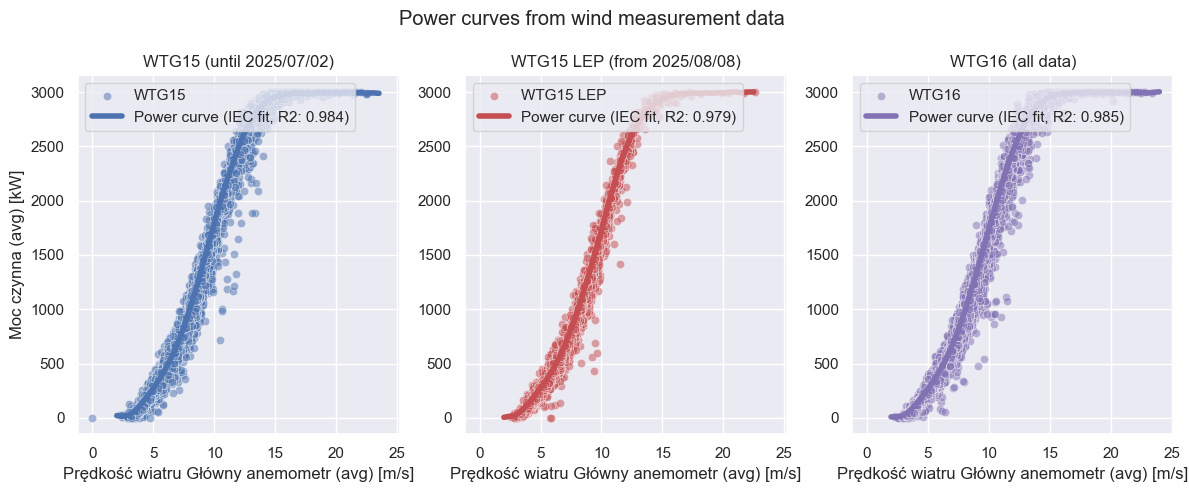

In [134]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12, 5))

for i, wt in enumerate(['WTG15', 'WTG15 LEP', 'WTG16']):
    ax = axes[i]
    df_wt = df[df.WTG==wt].copy()
    sns.scatterplot(data=df_wt.iloc[::10], x='Prędkość wiatru Główny anemometr (avg) [m/s]', y='Moc czynna (avg) [kW]', alpha=0.5,
                    ax=ax, color=color_dict[wt], label=wt)
    ax.yaxis.set_tick_params(labelbottom=True) 
    #ax.set_ylabel(columns_translation['ActivePower'])
    #ax.set_xlabel(columns_translation['WindSpeed'])
    if wt == 'WTG15':
        title = 'WTG15 (until 2025/07/02)'
    elif wt == 'WTG15 LEP':
        title = 'WTG15 LEP (from 2025/08/08)'
    elif wt == 'WTG16':
        title = 'WTG16 (all data)'
    ax.set_title(title)

    # plot power curve
    wind_speed_grid = np.arange(0, 25, 0.1)
    model, R2 = power_curves[wt]['IEC']
    sns.lineplot(x=wind_speed_grid, y=model(wind_speed_grid), alpha=1,
                  color=color_dict[wt], ax = ax, linewidth=4, label=f'Power curve (IEC fit, R2: {R2:.3f})')
    
fig.suptitle('Power curves from wind measurement data')
plt.tight_layout()
#Helpers.add_watermark(ax)

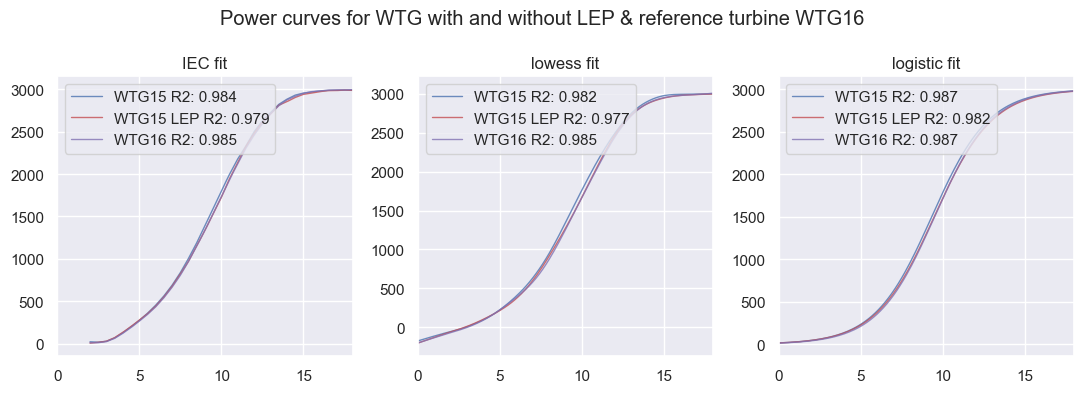

In [138]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 4))
wind_speed_grid = np.arange(0, 27, 0.1)

for col, model_name in enumerate(['IEC', 'lowess', 'logistic']):
    for row, wt in enumerate(['WTG15', 'WTG15 LEP', 'WTG16']):
        ax = axes[col]
        
        model, R2 = power_curves[wt][model_name]
        if model_name == 'lowess':
                predictions = model.predict(wind_speed_grid)
        elif model_name == 'logistic':
            predictions = logistic(wind_speed_grid, *model)
        else:
            predictions = model(wind_speed_grid)
        sns.lineplot(x=wind_speed_grid, y=predictions,
                    color=color_dict[wt], alpha=0.8, ax = ax, linewidth=1,
                    label=f'{wt} R2: {R2:.3f}')
        ax.set_title(f'{model_name} fit')
        ax.set_xlim((0, 18))

fig.suptitle('Power curves for WTG with and without LEP & reference turbine WTG16')
#Helpers.add_watermark(ax)
plt.tight_layout()

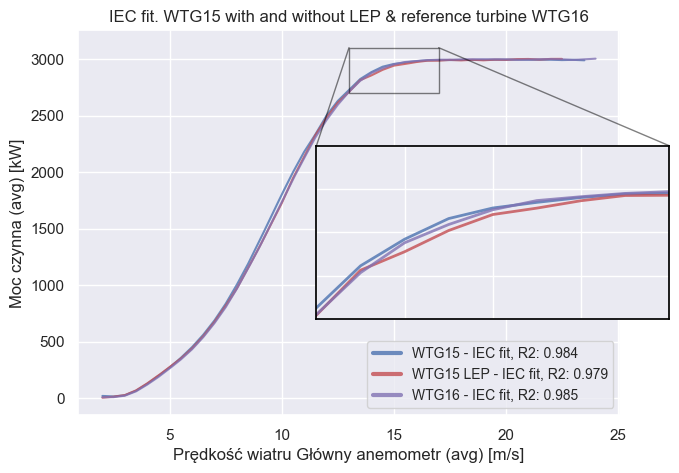

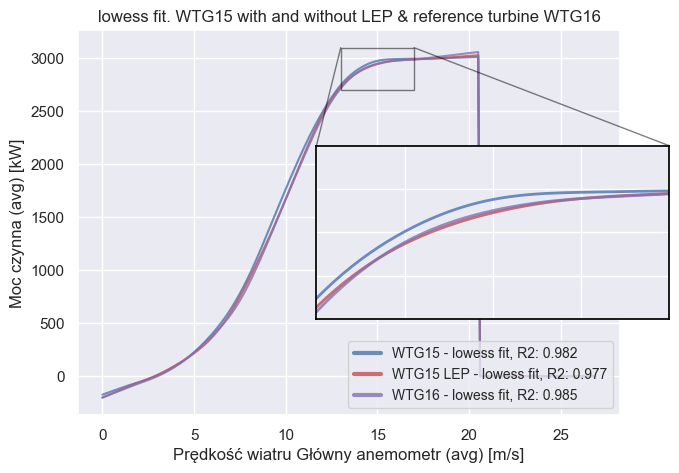

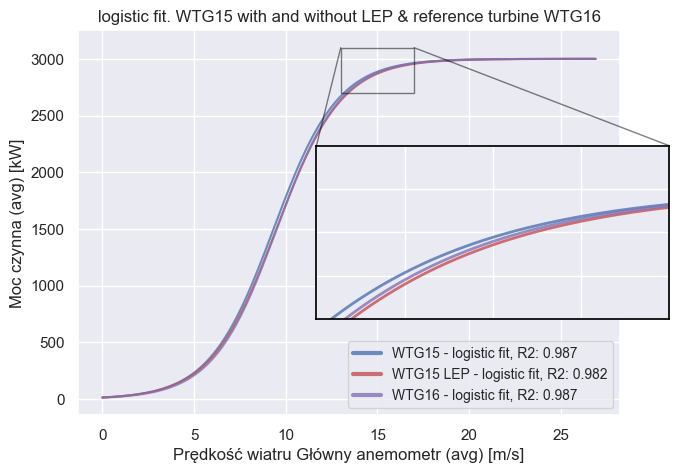

In [139]:
for model_name in ['IEC', 'lowess', 'logistic']:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
    #model_name = 'IEC'
    for wt in ['WTG15', 'WTG15 LEP', 'WTG16']:
        ax = axes
        model, R2 = power_curves[wt][model_name]
        if model_name == 'lowess':
                predictions = model.predict(wind_speed_grid)
        elif model_name == 'logistic':
            predictions = logistic(wind_speed_grid, *model)
        else:
            predictions = model(wind_speed_grid)
        sns.lineplot(x=wind_speed_grid, y=predictions,
                    color=color_dict[wt], alpha=0.8, ax = ax, linewidth=1.5,
                    label=f'{wt} - {model_name} fit, R2: {R2:.3f}')
        ax.set_xlabel('Prędkość wiatru Główny anemometr (avg) [m/s]')
        ax.set_ylabel('Moc czynna (avg) [kW]')

    #plot again for zoomed axes
    with plt.rc_context({'axes.edgecolor':'black'}):
        ax_zoomed = ax.inset_axes([0.44, 0.25, 0.65, 0.45])
    x1, x2, y1, y2 = 13, 17, 2700, 3100
    ax_zoomed.set_xlim(x1, x2)
    ax_zoomed.set_ylim(y1, y2)
    ax_zoomed.set_xticklabels([])
    ax_zoomed.set_yticklabels([])
    ax.indicate_inset_zoom(ax_zoomed, edgecolor="black")
    lgnd = ax.legend(loc="lower right", fontsize=10)
    for handles in lgnd.legend_handles:
        handles.set_linewidth(3)

    for wt in ['WTG15', 'WTG15 LEP', 'WTG16']:
        ax_zoomed
        model, R2 = power_curves[wt][model_name]
        if model_name == 'lowess':
            predictions = model.predict(wind_speed_grid)
        elif model_name == 'logistic':
            predictions = logistic(wind_speed_grid, *model)
        else:
            predictions = model(wind_speed_grid)
        sns.lineplot(x=wind_speed_grid, y=predictions,
                    color=color_dict[wt], alpha=0.8, ax = ax_zoomed, linewidth=2)
    ax.set_title(f'{model_name} fit. WTG15 with and without LEP & reference turbine WTG16')


In [90]:
df['Względny kierunek wiatru Główny wiatrowskaz (avg) [°]'].value_counts().sort_index()

Względny kierunek wiatru Główny wiatrowskaz (avg) [°]
-179.0    1
-162.0    1
-148.0    1
-143.0    1
-138.0    1
         ..
 85.0     1
 88.0     1
 89.0     1
 101.0    1
 149.0    1
Name: count, Length: 162, dtype: int64

### 5.2.X Wzgledny kierunek wiatru dla kazdej WTG

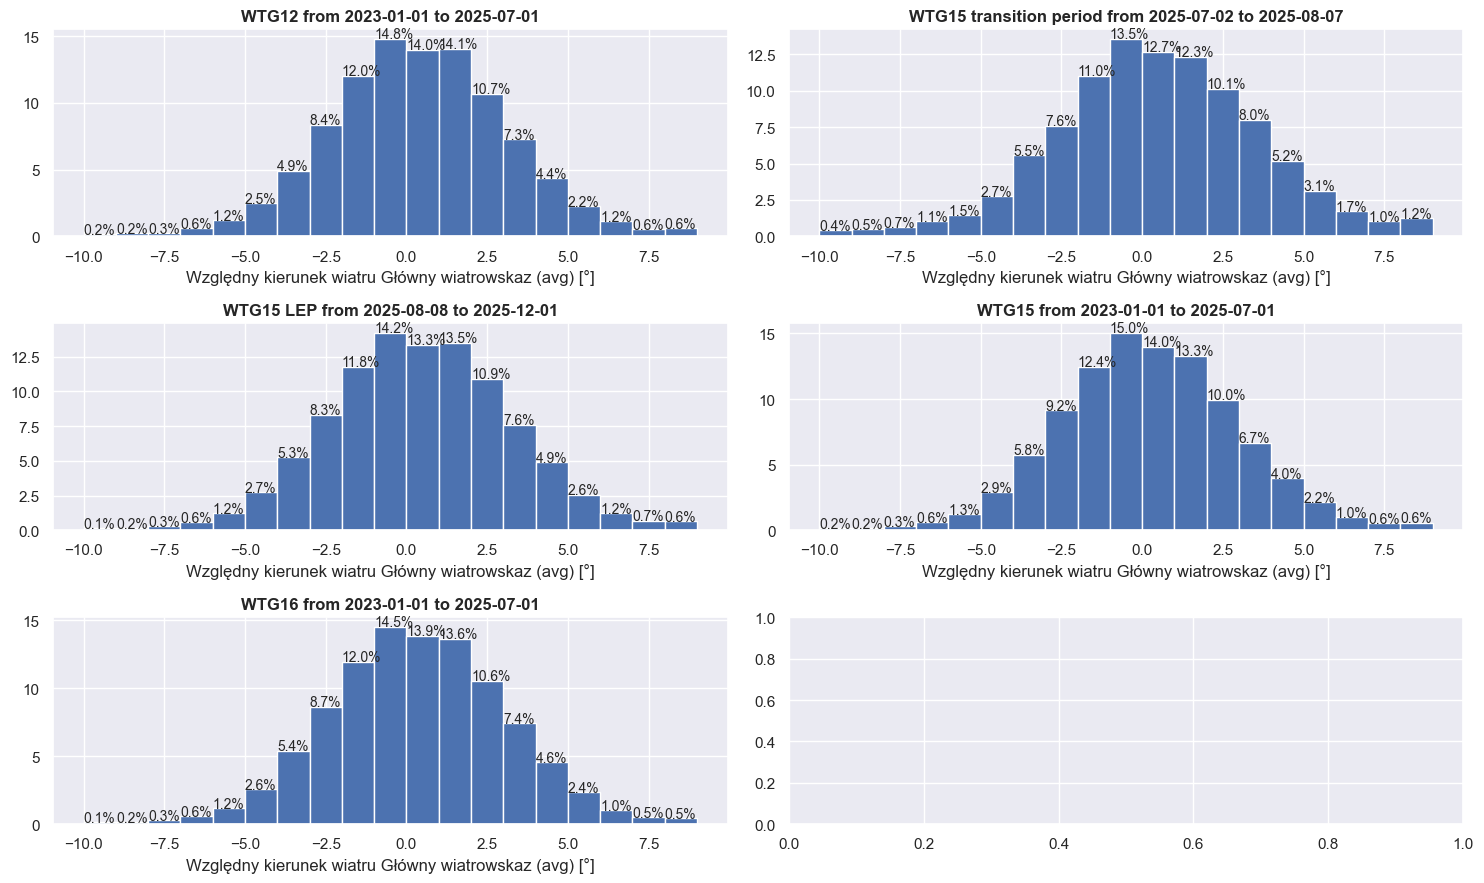

In [94]:
# plot histogram of Względny kierunek wiatru Główny wiatrowskaz (avg) [°] per different WTG
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,9))
bins = np.arange(-10, 10, 1)
for i, wtg in enumerate(df_raw['WTG'].unique()):
    ax = axes.flatten()[i]
    df_temp =  df_raw[df_raw['WTG'] == wtg]
    c, bins = np.histogram(df_temp['Względny kierunek wiatru Główny wiatrowskaz (avg) [°]'], bins=bins)
    ax.bar(x=bins[:-1], height=c/sum(c)*100, width=np.diff(bins), align='edge')
    Helpers.add_plt_annotations(ax, suffix='%')
    ax.set_xlabel('Względny kierunek wiatru Główny wiatrowskaz (avg) [°]')
    ax.set_title(f"{wtg} from {df_temp['Sygnatura czasowa'].dt.date.min()} to {df_temp['Sygnatura czasowa'].dt.date.max()}", fontweight='bold')
plt.tight_layout()

### 5.2.3 P vs P_ref

Narazie zostawione bo nie mamy pomiarów mocy z turbiny referencyjnej po instalacji LEP

In [98]:
df_time_index = df.set_index(['Sygnatura czasowa', 'WTG']).copy()
df_time_index

,,Temp otoczenia (avg) [°C],Kierunek wiatru Główny wiatrowskaz (avg) [°],Prędkość wiatru Główny anemometr (avg) [m/s],Kierunek Gondola (avg) [°],Całkowita produkcja energii czynnej (sum) [Wh],Moc czynna (avg) [W],Bezwzględny kierunek wiatru LaPM (avg) [°],Względny kierunek wiatru Główny wiatrowskaz (avg) [°],Czas pracy (co godzinę) [%],Całkowita produkcja energii biernej (sum) [VArh],Moc czynna (avg) [kW],WTG_simple,Wyprodukowana Energia [MWh]
Sygnatura czasowa,WTG,,,,,,,,,,,,,
2023-01-01 00:10:00,WTG12,14.0,220.0,13.3,221.0,444355.0,2709000.0,0.0,-1.0,NaN,NaN,2709.000,WTG12,0.444355
2023-01-01 00:20:00,WTG12,14.0,222.0,13.1,221.0,395165.0,2344300.0,0.0,1.0,NaN,NaN,2344.300,WTG12,0.839520
2023-01-01 00:30:00,WTG12,14.0,225.0,12.8,224.0,299918.0,1799400.0,0.0,1.0,NaN,NaN,1799.400,WTG12,1.139438
2023-01-01 00:40:00,WTG12,14.0,223.0,12.9,227.0,300029.0,1800199.0,0.0,-4.0,NaN,NaN,1800.199,WTG12,1.439467
2023-01-01 06:20:00,WTG12,16.0,227.0,12.1,225.0,221518.0,1329099.0,0.0,1.0,NaN,NaN,1329.099,WTG12,1.660985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-01 23:10:00,WTG16,22.0,124.0,4.4,116.0,25332.0,152600.0,0.0,9.0,NaN,NaN,152.600,WTG16,17531.290107
2025-07-01 23:20:00,WTG16,22.0,125.0,5.1,125.0,37123.0,223500.0,0.0,0.0,NaN,NaN,223.500,WTG16,17531.327230
2025-07-01 23:30:00,WTG16,22.0,128.0,5.6,125.0,45411.0,272899.0,0.0,3.0,NaN,NaN,272.899,WTG16,17531.372641


In [ ]:
df_p_wtg16 = df[df['WTG']=='WTG16'][['Sygnatura czasowa', 'Prędkość wiatru Główny anemometr (avg) [m/s]', 'Moc czynna (avg) [kW]']].values
df_p_wtg15 = df[df['WTG']=='WTG15'][['Sygnatura czasowa', 'Prędkość wiatru Główny anemometr (avg) [m/s]', 'Moc czynna (avg) [kW]']].values
df_p_wtg15_lep = df[df['WTG']=='WTG15 LEP'][['Sygnatura czasowa', 'Prędkość wiatru Główny anemometr (avg) [m/s]', 'Moc czynna (avg) [kW]']].values

### 5.2.4 Symulacja WTG15 w 2024

In [169]:
df_WTG15_time_2024 = df[(df['WTG']=='WTG15') & df['Sygnatura czasowa'].between(pd.to_datetime('2024/08/08'), pd.to_datetime('2024/12/01'))].copy()
df_WTG15_time_2024['WTG'] = 'WTG15 2024_08_to_12'
df_symulacja = pd.concat([df, df_WTG15_time_2024], ignore_index=True)

In [172]:
df_symulacja[df_symulacja['WTG'] == 'WTG15 2024_08_to_12'].groupby(df_symulacja['Prędkość wiatru Główny anemometr (avg) [m/s]']//1).size().sort_index()

Prędkość wiatru Główny anemometr (avg) [m/s]
0.0        1
2.0       66
3.0     1233
4.0     1672
5.0     1879
6.0     1834
7.0     1777
8.0     1840
9.0     1613
10.0     911
11.0     501
12.0     285
13.0     176
14.0      98
15.0      68
16.0      19
17.0       2
18.0       1
dtype: int64

In [173]:
power_curves_symulacja = {}
df_fit_symulacja = df_symulacja[df_symulacja['Prędkość wiatru Główny anemometr (avg) [m/s]'].between(2, 27)].copy()
wind_range=(2, 18)
samples_per_bin=20
for i, wtg in enumerate(df_symulacja['WTG'].unique()):
    if wtg == 'WTG15 transition period':
        continue
    df_wtg = df_fit_symulacja[df_fit_symulacja.WTG == wtg]
    power_curves_symulacja[wtg] = {}

    # Fit models
    # !!! when more data is provided samples per bin and wind_range should be increased !!!
    [L, k, x0], R2_logistic = fit_logistic_power_curve(df_wtg['Prędkość wiatru Główny anemometr (avg) [m/s]'], df_wtg['Moc czynna (avg) [kW]'], samples_per_bin=19, wind_range=(2, 16)) 
    lowess_model, R2_lowess = fit_lowess_power_curve(df_wtg['Prędkość wiatru Główny anemometr (avg) [m/s]'], df_wtg['Moc czynna (avg) [kW]'], samples_per_bin=19, wind_range=(2, 16))

    #[L, k, x0], R2_logistic = fit_logistic_power_curve(df_wtg['Prędkość wiatru Główny anemometr (avg) [m/s]'], df_wtg['Moc czynna (avg) [kW]'], samples_per_bin=200, wind_range=(3, 13)) 
    #lowess_model, R2_lowess = fit_lowess_power_curve(df_wtg['Prędkość wiatru Główny anemometr (avg) [m/s]'], df_wtg['Moc czynna (avg) [kW]'], samples_per_bin=200, wind_range=(3, 13))
    

    IEC_model, R2_IEC = fit_power_curve_IEC(df_wtg['Prędkość wiatru Główny anemometr (avg) [m/s]'], df_wtg['Moc czynna (avg) [kW]'])

    power_curves_symulacja[wtg]['logistic'] = [[L, k, x0], R2_logistic]
    power_curves_symulacja[wtg]['lowess'] = [lowess_model, R2_lowess]
    #power_curves[wtg]['poly6'] = [poly6_model, R2_poly6] # poly6 is shit, we'll not continue with that one < since that was conclusion last time, we'll skip it this time as well
    power_curves_symulacja[wtg]['IEC'] = [IEC_model, R2_IEC]
    
power_curves_symulacja

C:\Users\wikto\AppData\Local\Temp\ipykernel_25860\845154387.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results = power.groupby(windSpeedBin).mean().reset_index()
C:\Users\wikto\AppData\Local\Temp\ipykernel_25860\845154387.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results = power.groupby(windSpeedBin).mean().reset_index()
C:\Users\wikto\AppData\Local\Temp\ipykernel_25860\845154387.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future def

{'WTG12': {'logistic': [[2993.3989999999994,
    0.5393647089699752,
    9.62499367554191],
   0.9890435524233867],
  'lowess': [Lowess(), 0.9756992013940773],
  'IEC': [<scipy.interpolate._interpolate.interp1d at 0x248924d7680>,
   0.9865600840523961]},
 'WTG15': {'logistic': [[2996.898999999999,
    0.5863154254573614,
    9.415567198250246],
   0.9862715405862881],
  'lowess': [Lowess(), 0.9812040170938432],
  'IEC': [<scipy.interpolate._interpolate.interp1d at 0x24892694db0>,
   0.9841035100591723]},
 'WTG15 LEP': {'logistic': [[2978.5999999999976,
    0.5853170347295038,
    9.435470834299993],
   0.9809358742939114],
  'lowess': [Lowess(), 0.9801298567999305],
  'IEC': [<scipy.interpolate._interpolate.interp1d at 0x248926949f0>,
   0.9788414653139208]},
 'WTG16': {'logistic': [[3001.4999999999877,
    0.5748701561939388,
    9.51700460941315],
   0.9870321359462066],
  'lowess': [Lowess(), 0.9762059698843432],
  'IEC': [<scipy.interpolate._interpolate.interp1d at 0x248926949a0>,


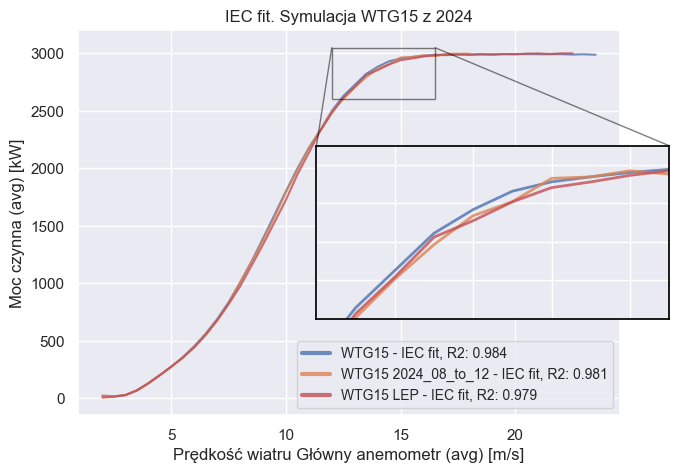

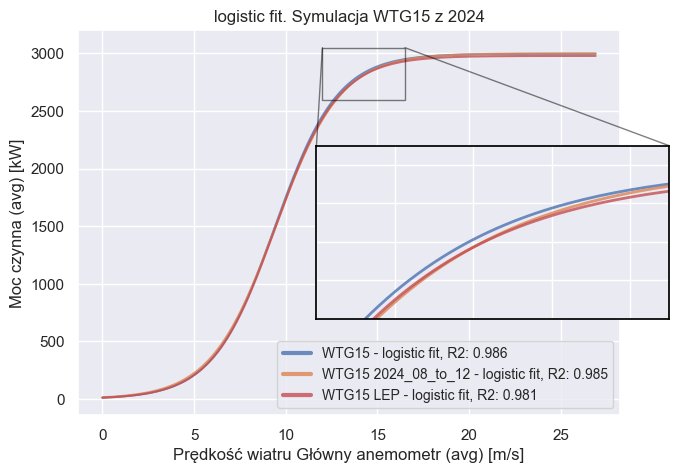

In [179]:
for model_name in ['IEC', 'logistic']:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
    #model_name = 'IEC'
    for wt in ['WTG15', 'WTG15 2024_08_to_12', 'WTG15 LEP']:
        ax = axes
        model, R2 = power_curves_symulacja[wt][model_name]
        if model_name == 'lowess':
                predictions = model.predict(wind_speed_grid)
        elif model_name == 'logistic':
            predictions = logistic(wind_speed_grid, *model)
        else:
            predictions = model(wind_speed_grid)
        sns.lineplot(x=wind_speed_grid, y=predictions,
                    color=color_dict[wt], alpha=0.8, ax = ax, linewidth=1.5,
                    label=f'{wt} - {model_name} fit, R2: {R2:.3f}')
        ax.set_xlabel('Prędkość wiatru Główny anemometr (avg) [m/s]')
        ax.set_ylabel('Moc czynna (avg) [kW]')

    #plot again for zoomed axes
    with plt.rc_context({'axes.edgecolor':'black'}):
        ax_zoomed = ax.inset_axes([0.44, 0.25, 0.65, 0.45])
    x1, x2, y1, y2 = 12, 16.5, 2600, 3050
    ax_zoomed.set_xlim(x1, x2)
    ax_zoomed.set_ylim(y1, y2)
    ax_zoomed.set_xticklabels([])
    ax_zoomed.set_yticklabels([])
    ax.indicate_inset_zoom(ax_zoomed, edgecolor="black")
    lgnd = ax.legend(loc="lower right", fontsize=10)
    for handles in lgnd.legend_handles:
        handles.set_linewidth(3)

    for wt in ['WTG15', 'WTG15 2024_08_to_12', 'WTG15 LEP']:
        ax_zoomed
        model, R2 = power_curves_symulacja[wt][model_name]
        if model_name == 'lowess':
            predictions = model.predict(wind_speed_grid)
        elif model_name == 'logistic':
            predictions = logistic(wind_speed_grid, *model)
        else:
            predictions = model(wind_speed_grid)
        sns.lineplot(x=wind_speed_grid, y=predictions,
                    color=color_dict[wt], alpha=0.8, ax = ax_zoomed, linewidth=2)
    ax.set_title(f'{model_name} fit. Symulacja WTG15 z 2024')
